<a href="https://colab.research.google.com/github/arghya53/TimeSeriesAnalysis/blob/main/Deep_Learning_Time_Series_Forecasting_Using_Gluon_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DeepAR is a supervised learning algorithm for time series forecasting that internally trains an autoregressive RNN to produce both point in time as well as probabilistic forecast. It can work seamlessly work on multiple time series. As we know time series of products may vary depending on season, so we need to build several local models based on their respective time series. But DeepAR can work on to create single local model when there is multiple timeseries scenerios and handle them seamlessly by developing one single model. It is quite easier to create a DeepAR model than manually creating an LSTM model.

We have data from 2016-01-11 17:00:00	to 2016-05-27 18:00:00	at a 10 minutes interval. We are taking data upto 10th May and rest of data upto 27th May we are using for testing.  The model will use the previous 720 data points(5 days' data) to make predictions for future 144 time points(24 hrs)

In [ ]:
!pip install mxnet
!pip install gluonts
!pip install orjson

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from gluonts.mx.trainer import Trainer
from gluonts.mx.model.deepar import DeepAREstimator
import numpy as np
mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

In [ ]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv')

In [ ]:
df

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,...,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,...,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,...,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784


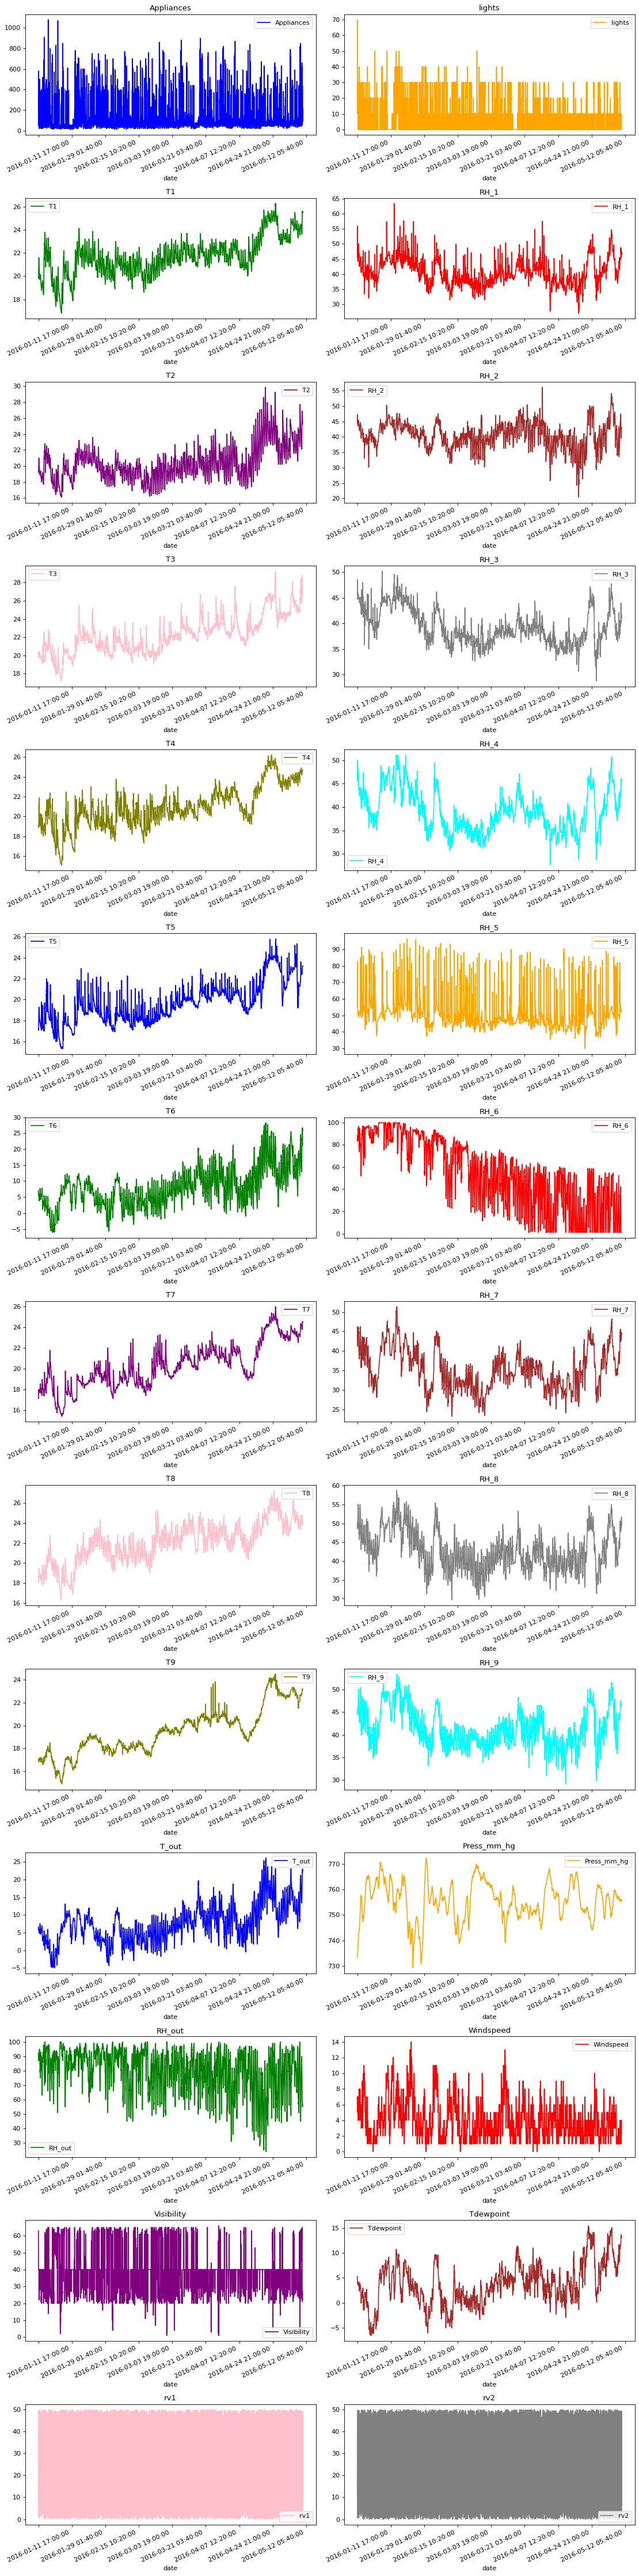

In [ ]:
color_list = [
    'blue',
    'orange',
    'green',
    'red',
    'purple',
    'brown',
    'pink',
    'gray',
    'olive',
    'cyan'
]

date_key = 'date'

def Visualize(data):
  time_data = data[date_key]
  features= list(df.select_dtypes(include=[np.number]).columns.values)
  feature_size=len(features)
  fig, axes = plt.subplots(
      nrows=int(np.ceil(feature_size/2)), ncols=2, figsize=(14, feature_size*2), dpi=80, facecolor='w', edgecolor='k'
  )
  for i in range(feature_size):
    key = features[i]
    c = color_list[i % (len(color_list))]
    t_data= data[key]
    t_data.index = time_data
    t_data.head()

    ax = t_data.plot(

        ax = axes[i // 2, i % 2],
        color = c,
        title = '{}'.format(key),
        rot = 25
    )
    ax.legend([key])
  plt.tight_layout()

Visualize(df)

Our target is to predict the appliances usage for the next 720 data points

---



In [ ]:
df_input = df[['date', 'Appliances', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Tdewpoint', 'Visibility']]

In [ ]:
df_input = df_input.set_index('date')

In [ ]:
train_time = '2016-05-10 00:00:00'
prediction_length = 144 # 24 hrs

In [ ]:
estimator = DeepAREstimator(freq = '10min',
                            context_length = 720,
                            prediction_length = prediction_length,
                            num_layers = 2,
                            num_cells = 128,
                            cell_type = 'lstm',
                            trainer = Trainer(epochs=8))

# context_length: the model will use the previous 720 data points(5 days' data) to make predictions for future 144 time points(24 hrs)
# the LSTM layer in the neural network model is using 2 layers
# 120 cells in each LSTM layer
# epochs=8: the DeepAR model will be trained through 8 complete passes of the training data

In [ ]:
# Now we are going to feed the model with dataset
# we are training the model for univariate analysis from date 2016-01-11 17:00:00 to 2016-05-10 00:00:00, to predict usage of the Target(appliances)
from gluonts.dataset.common import ListDataset

training_data = ListDataset([{'start': df_input.index[0], 'target': df_input.Appliances[:train_time]}],
                            freq = '10min'
                           )


In [ ]:
predictor = estimator.train(training_data=training_data)

# the model is getting trained. By default it is 50 steps per epoch(total 8 epochs)

100%|██████████| 50/50 [02:03<00:00,  2.47s/it, epoch=8/8, avg_epoch_loss=4.4]


In [ ]:
test_data = ListDataset(
    [
        {'start': df_input.index[0], 'target': df_input.Appliances[:'2016-05-11 00:00:00']},
        {'start': df_input.index[0], 'target': df_input.Appliances[:'2016-05-16 00:00:00']}
    ],
    freq = '10min'
)

In [ ]:
from gluonts.evaluation.backtest import make_evaluation_predictions


test_data = ListDataset(
    [
        {"start": df_input.index[0], "target": df_input.Appliances[:"2016-05-11 00:00:00"]},
        {"start": df_input.index[0], "target": df_input.Appliances[:"2016-05-15 00:00:00"]}
    ],
    freq = "10min"
)

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset= test_data,
    predictor= predictor,
    num_samples = 100
)
# forecast_it represents that for each time series 100 forecasted samples will be stored in it.
# ts_it is the time series iterator which provides actual time series data from the test_dataset.
# We are going to compare the values from tss with the forecast values.

In [ ]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [ ]:
forecasts

[gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[  51.50346  ,   46.63523  ,   40.54997  , ..., -171.77562  ,
          -92.93382  ,    5.1511755],
        [  56.330345 ,   47.670082 ,   54.062206 , ...,   31.691856 ,
           51.01665  ,   35.088173 ],
        [  43.355976 ,   26.652502 ,   30.562218 , ...,   34.56759  ,
           45.7054   ,   49.514977 ],
        ...,
        [  54.218014 ,   56.629837 ,   50.256954 , ...,   56.72708  ,
           57.37775  ,   53.75659  ],
        [  45.558502 ,   25.64598  ,   33.456345 , ...,   41.45928  ,
           48.57645  ,   34.95133  ],
        [  45.795483 ,   48.40372  ,   38.288918 , ...,   32.060703 ,
           49.84582  ,   44.313328 ]], dtype=float32), start_date=Period('2016-05-10 00:10', '10T')),
 gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[48.006824, 49.06318 , 42.194508, ..., 50.42043 , 58.94093 ,
         39.018112],
        [34.022728, 40.614326, 47.439102, .

In [ ]:
forecast_entry = forecasts[0]
ts_entry = tss[0]

In [ ]:
forecast_entry

gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[  51.50346  ,   46.63523  ,   40.54997  , ..., -171.77562  ,
         -92.93382  ,    5.1511755],
       [  56.330345 ,   47.670082 ,   54.062206 , ...,   31.691856 ,
          51.01665  ,   35.088173 ],
       [  43.355976 ,   26.652502 ,   30.562218 , ...,   34.56759  ,
          45.7054   ,   49.514977 ],
       ...,
       [  54.218014 ,   56.629837 ,   50.256954 , ...,   56.72708  ,
          57.37775  ,   53.75659  ],
       [  45.558502 ,   25.64598  ,   33.456345 , ...,   41.45928  ,
          48.57645  ,   34.95133  ],
       [  45.795483 ,   48.40372  ,   38.288918 , ...,   32.060703 ,
          49.84582  ,   44.313328 ]], dtype=float32), start_date=Period('2016-05-10 00:10', '10T'))

In [ ]:
ts_entry

,0
2016-01-11 17:00,60.0
2016-01-11 17:10,60.0
2016-01-11 17:20,50.0
2016-01-11 17:30,50.0
2016-01-11 17:40,60.0
...,...
2016-05-10 23:20,60.0
2016-05-10 23:30,50.0
2016-05-10 23:40,70.0
2016-05-10 23:50,50.0


In [ ]:
def plot_prob_forecasts(ts_entry, forecast_entry):
  plot_length = prediction_length
  prediction_intervals = (80, 95)
  legend = ['observations' 'median predictions'] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

  fig, ax = plt.subplots(1, 1, figsize=(10, 7))
  ts_entry[-plot_length:].plot(ax=ax)
  forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
  plt.grid(which = 'both')
  plt.legend(legend, loc='upper left')
  plt.show()

TypeError: ignored

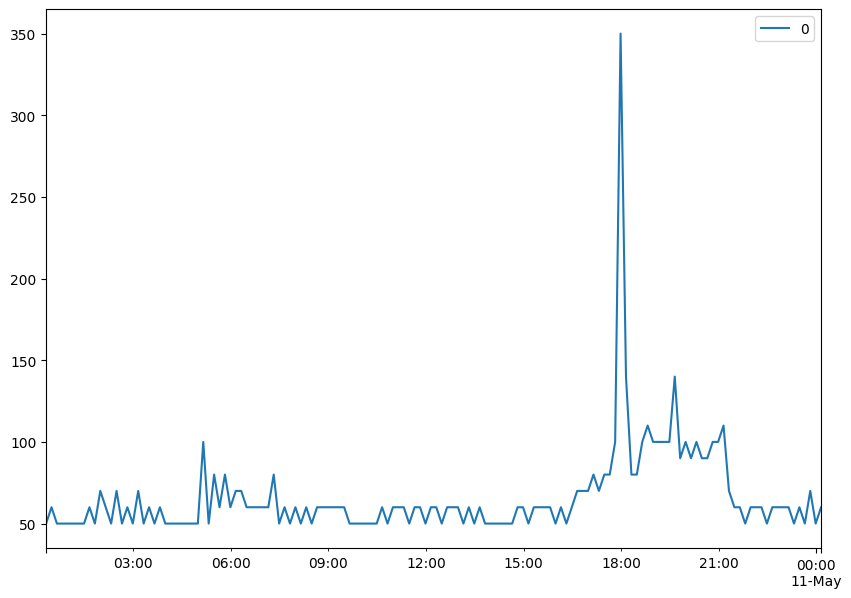

In [ ]:
plot_prob_forecasts(tss[0], forecasts[0])
plot_prob_forecasts(tss[1], forecasts[1])